## PDS Group 7

### Data Prep

In [1]:
import pandas as pd
import numpy as np

pd.set_option("mode.copy_on_write", True)

In [3]:
df = pd.read_csv("threshold.csv")
df.columns

Index(['Buyer State', 'Buyer County', 'Total_MME', 'County', 'County Code',
       'Drug/Alcohol Induced Cause', 'Drug/Alcohol Induced Cause Code',
       'Deaths', 'Year', 'Population'],
      dtype='object')

In [4]:
# check unique states
df["Buyer State"].unique()

array(['GA', 'NC', 'FL', 'SC', 'WA', 'MT', 'OR', 'ID'], dtype=object)

In [5]:
# Calculate OD mortality rate on state-year level
mort_rate = df.groupby(["Buyer State", "Year"], as_index=False).agg(
    {"Deaths": "sum", "Population": "sum"}
)

mort_rate["Overdose Deaths per capita"] = mort_rate["Deaths"] / mort_rate["Population"]

mort_rate.sample(10)

,Buyer State,Year,Deaths,Population,Overdose Deaths per capita
50,OR,2006,3640,54701387,0.000067
33,MT,2009,175,1159560,0.000151
60,SC,2006,4862,42396031,0.000115
19,GA,2015,8670,70962075,0.000122
28,ID,2014,605,5248740,0.000115
4,FL,2010,302064,2916428726,0.000104
11,GA,2007,16983,198793896,0.000085
3,FL,2009,148676,1282069232,0.000116
7,FL,2013,116436,1493604800,0.000078
49,NC,2015,14265,105355935,0.000135


In [7]:
mme_rate = df.groupby(["Buyer State", "Year"], as_index=False).agg(
    {"Total_MME": "sum", "Population": "sum"}
)

mme_rate["MME per capita"] = mme_rate["Total_MME"] / mme_rate["Population"]

mme_rate.sample(10)

,Buyer State,Year,Total_MME,Population,MME per capita
60,SC,2006,5.208464e+06,42396031,0.122853
14,GA,2010,1.161199e+11,511082406,227.203902
17,GA,2013,2.321347e+08,236601236,0.981122
41,NC,2007,4.763144e+07,220645637,0.215873
68,SC,2014,7.540987e+06,51982565,0.145068
61,SC,2007,5.807572e+06,37994218,0.152854
12,GA,2008,2.171728e+08,250399498,0.867305
30,MT,2006,1.309316e+05,697910,0.187605
47,NC,2013,1.274518e+11,282301257,451.474503
4,FL,2010,1.289043e+12,2916428726,441.993651


In [9]:
# Aggregate overdose data to state-year level
states = df.groupby(["Buyer State", "Year"], as_index=False)["Total_MME"].sum()

states = states.merge(
    mort_rate,
    left_on=["Buyer State", "Year"],
    right_on=["Buyer State", "Year"],
    how="inner",
)
states = states.merge(
    mme_rate,
    left_on=["Buyer State", "Year"],
    right_on=["Buyer State", "Year"],
    how="inner",
)

states = states[["Buyer State", "Year", "Overdose Deaths per capita", "MME per capita"]]
states.sample(10)

,Buyer State,Year,Overdose Deaths per capita,MME per capita
57,OR,2013,0.000075,0.169858
54,OR,2010,0.000063,139.179803
8,FL,2014,0.000083,978.934347
47,NC,2013,0.000105,451.474503
42,NC,2008,0.000107,99.681465
58,OR,2014,0.000069,0.166467
26,ID,2012,0.000092,0.245595
72,WA,2008,0.000096,0.077105
24,ID,2010,0.000097,0.184332
21,ID,2007,0.000085,0.159434


### Flordia

In [12]:
# Separate Florida and its control states
df_fl = states[states["Buyer State"] == "FL"]
df_fl_control = states[states["Buyer State"].isin(["NC", "SC", "GA"])]

In [13]:
# Aggregate to year level
fl_grouped = df_fl.groupby("Year", as_index=False)[
    ["Overdose Deaths per capita", "MME per capita"]
].mean()

control_fl_grouped = df_fl_control.groupby("Year", as_index=False)[
    ["Overdose Deaths per capita", "MME per capita"]
].mean()

In [16]:
# add group labels
fl_grouped["Group"] = "Florida"
control_fl_grouped["Group"] = "Control (NC, SC, GA)"

# combine fl and control
fl_combined = pd.concat([fl_grouped, control_fl_grouped])

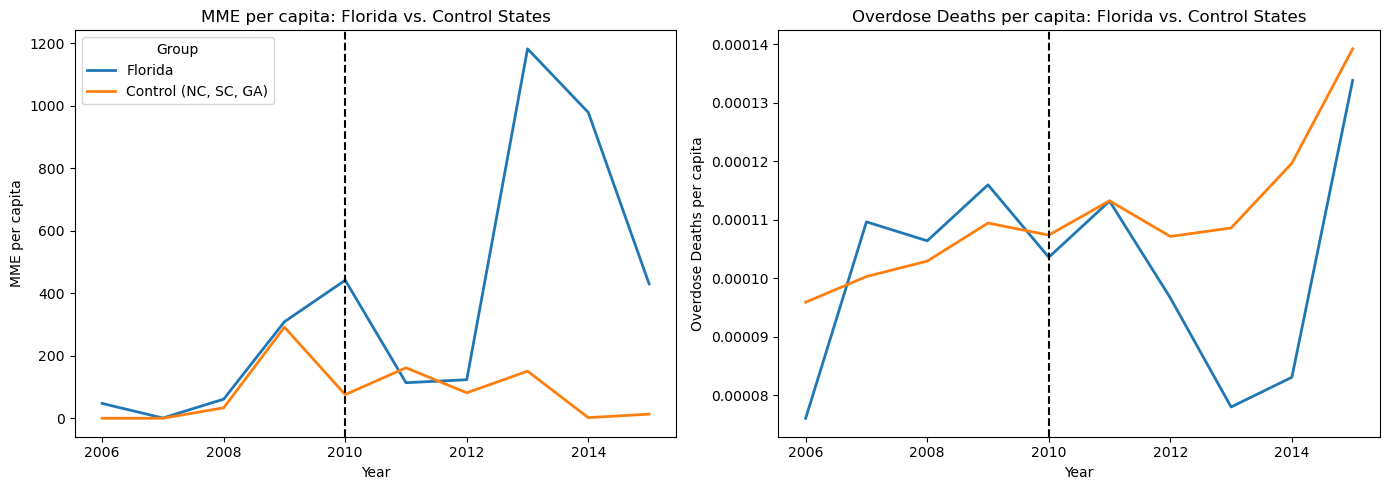

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

# Chart 1: MME per capita vs. Year
sns.lineplot(
    data=fl_combined,
    x="Year",
    y="MME per capita",
    hue="Group",
    ax=axes[0],
    linewidth=2.0,
    marker=None,  # no dots
)
axes[0].set_title("MME per capita: Florida vs. Control States")
axes[0].set_ylabel("MME per capita")
axes[0].set_xlabel("Year")
axes[0].axvline(x=2010, color="black", linestyle="--", linewidth=1.5)  # vertical line

# Chart 2: Overdose Deaths per capita vs. Year
sns.lineplot(
    data=fl_combined,
    x="Year",
    y="Overdose Deaths per capita",
    hue="Group",
    ax=axes[1],
    linewidth=2.0,
    marker=None,
)
axes[1].set_title("Overdose Deaths per capita: Florida vs. Control States")
axes[1].set_ylabel("Overdose Deaths per capita")
axes[1].set_xlabel("Year")
axes[1].axvline(x=2010, color="black", linestyle="--", linewidth=1.5)

# Adjust legends and layout
axes[1].get_legend().remove()  # keep only one legend
axes[0].legend(title="Group")
plt.tight_layout()
plt.show()

### Washington

In [23]:
# Separate Washignton and its control states
df_wa = states[states["Buyer State"] == "WA"]
df_wa_control = states[states["Buyer State"].isin(["MT", "OR", "ID"])]

In [24]:
# Aggregate to year level
wa_grouped = df_wa.groupby("Year", as_index=False)[
    ["Overdose Deaths per capita", "MME per capita"]
].mean()

control_wa_grouped = df_wa_control.groupby("Year", as_index=False)[
    ["Overdose Deaths per capita", "MME per capita"]
].mean()

In [25]:
# add group labels
wa_grouped["Group"] = "Washinton"
control_wa_grouped["Group"] = "Control (MT, OR, ID)"

# combine fl and control
wa_combined = pd.concat([wa_grouped, control_wa_grouped])

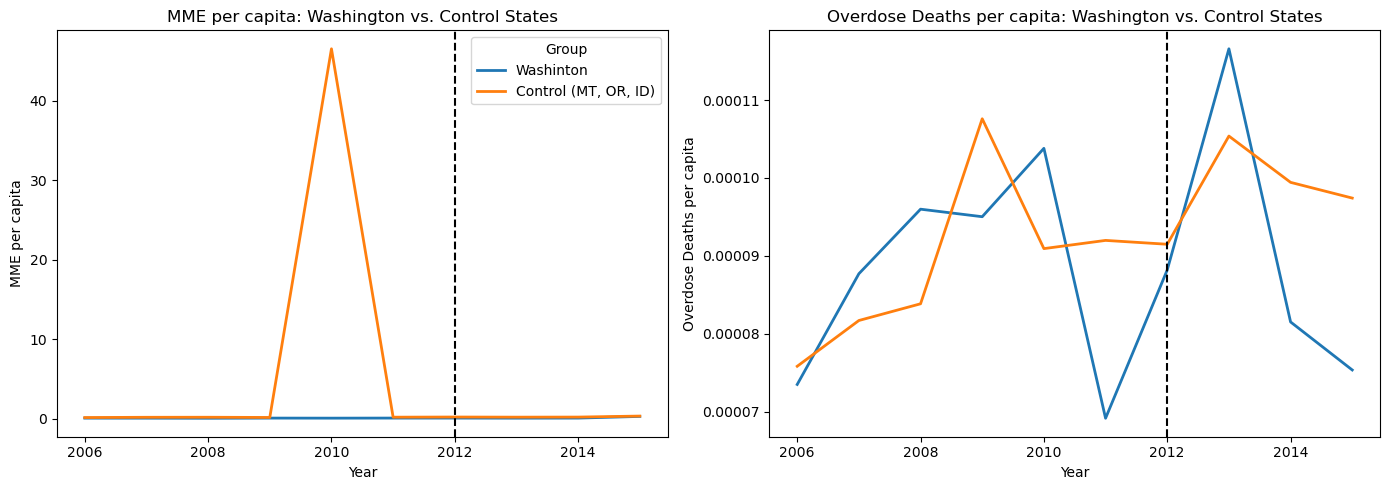

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

# Chart 1: MME per capita vs. Year
sns.lineplot(
    data=wa_combined,
    x="Year",
    y="MME per capita",
    hue="Group",
    ax=axes[0],
    linewidth=2.0,
    marker=None,  # no dots
)
axes[0].set_title("MME per capita: Washington vs. Control States")
axes[0].set_ylabel("MME per capita")
axes[0].set_xlabel("Year")
axes[0].axvline(x=2012, color="black", linestyle="--", linewidth=1.5)  # vertical line

# Chart 2: Overdose Deaths per capita vs. Year
sns.lineplot(
    data=wa_combined,
    x="Year",
    y="Overdose Deaths per capita",
    hue="Group",
    ax=axes[1],
    linewidth=2.0,
    marker=None,
)
axes[1].set_title("Overdose Deaths per capita: Washington vs. Control States")
axes[1].set_ylabel("Overdose Deaths per capita")
axes[1].set_xlabel("Year")
axes[1].axvline(x=2012, color="black", linestyle="--", linewidth=1.5)

# Adjust legends and layout
axes[1].get_legend().remove()  # keep only one legend
axes[0].legend(title="Group")
plt.tight_layout()
plt.show()